# Genetic Algorithms for Parameter Optimization
## 1. Basic parts

First, we load necessary modules and set global parameter values.

In [1]:
# load modules
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
matplotlib.rcParams['text.usetex'] = True

from ea_operators import phenotypes
from ea_operators import initialize
from ea_operators import fitness
from ea_operators import crossover
from ea_operators import mutation
from ea_operators import selection
from ea_utilities import objective_functions
from ea_utilities import visualize

# from ea_algorithms.simple_ga import ga

We initialize the first-generation population with random binary numbers and print it out.
Each row in the resulting matrix corresponds to one individual in the population.

Each individual encodes $N$ reals in $[a; b]$ as follows.
An individual of length $N\cdot l$ is split into $N$ parts of length $l$.
Each such part represents one real in $[a; b]$:
* all zeros corresponds to $a$;
* all ones corresponds to $b$;
* everything else is mapped linearly onto reals in $[a; b]$.

For example, suppose we want to encode 3 parameters in $[-1; 2]$ and use $l = 5$ bits for each of them.
Then we can have a chromosome $10011\mid 01100\mid 01000$

Since $00000 \rightarrow -1$ and $11111 \rightarrow 2$, we compute
\begin{align*}
    10011 &\rightarrow \frac{19}{2^5 - 1} \cdot (2 - (-1)) + (-1) \approx 0.839\\
    01100 &\rightarrow \frac{12}{2^5 - 1} \cdot (2 - (-1)) + (-1) \approx 0.161\\
	01000 &\rightarrow \frac{8}{2^5 - 1} \cdot (2 - (-1)) + (-1) \approx -0.226
\end{align*}

To illustrate, let's compute fitness function
$f(\mathbf{x}) = x_1^2 + x_2^2 + x_3^2$.

In [8]:
# set random seed for reproducibility
np.random.seed(123)

# initializing the population
mu = 20  # population size
nvar = 3  # number of parameters
bits_num = 5  # bits to encode one parameter
a, b = -1, 2  # interval

population = initialize.initialize_real(
    mu, nvar, bits_num
)

print("Individuals:")
print(population)

# functions to pass into other functions
fitness_function = lambda x: np.sum(x**2, axis=1)
phenotype_function = lambda x: phenotypes.phenotype_real(
    x, a, b, nvar, bits_num
)

# the same can be achieved just by calling a fitness calculation function
# because it will also return individual phenotypes in the process
(individuals, fitnesses) = fitness.calculate_fitness(
    population, phenotype_function, fitness_function
)

print("Individuals:")
print(individuals)

print("Their fitness values:")
print(fitnesses)

Individuals:
[[1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0.]
 [1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1.]
 [1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1.]
 [0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1.]
 [0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0.]
 [1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1.]]
Individuals:
[[ 0.83870968

Now we can explore how $n$-point and uniform crossovers work.

For $n$-point crossovers, we generate $n$ random indexes, and
exchange the parts of the chromosome, alternating between two
parents.

For illustration purposes, we will use the two first individuals to cross over.

In [9]:
child1, child2, crossover_points, crossover_indices =\
    crossover.crossover_n_point(
        population[0:2,], population[2:4,],
        prob_crossover=1, return_meta_data=True, n=2
    )

print("Crossovers occurred at positions {}".format(crossover_points))
print("Parents:")
print(population[0:2,])
print(population[2:4,])
print("Children:")
print(child1)
print(child2)

Crossovers occurred at positions [[0 2]
 [3 7]]
Parents:
[[1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1.]]
Children:
[[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.]]
[[1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1.]]


For uniform crossover, we flip a coin for each single gene
and decide whether it should go from parent 1 to child 1 and
from parent 2 to child 2, or from parent 1 to child 2 and
from parent 2 to child 1.

In [12]:
child1, child2, crossover_points, crossover_indices =\
    crossover.crossover_uniform(
        population[0:2,], population[2:4,],
        prob_crossover=1, return_meta_data=True
    )

print("Random numbers that decided what goes where: {}".format(crossover_points))
print("Parents:")
print(population[0:2,])
print(population[2:4,])
print("Children:")
print(child1)
print(child2)

Random numbers that decided what goes where: [[0.11739844 0.30105336 0.14526373 0.0921861  0.6029322  0.36418745
  0.56457034 0.19133572 0.67690586 0.21550545 0.27802359 0.74176042
  0.5597379  0.33483641 0.54298878]
 [0.6939847  0.91213212 0.58071321 0.23268638 0.74669763 0.77776902
  0.20040131 0.82057422 0.46493485 0.77976666 0.23747822 0.33258027
  0.95369712 0.65781507 0.77287783]]
Parents:
[[1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1.]]
Children:
[[1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1.]]
[[0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0.]
 [1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1.]]
[[1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1.]]
[[33.  0.

## Maximizing test functions

Now we can combine everything in one big algorithm to be tried
on several test functions. The functions are taken from *An Analysis of the Behaviour of a Class of Genetic Adaptive
Systems* by K. A. De Jong (1975) and are commonly called *De Jong
functions*.

In [2]:
def plot_test_function(test_function, a, b):
    # create a grid of x and y values
    x = np.linspace(a, b, 100)
    y = np.linspace(a, b, 100)
    X, Y = np.meshgrid(x, y)
    xy_coordinates = np.column_stack((X.ravel(), Y.ravel()))

    # calculate z values
    result = test_function(xy_coordinates)
    Z = result.reshape(X.shape)

    # create a 3D figure with two subplots
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # plot the 3D surface
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')

    # add labels and a color bar
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('')
    fig.colorbar(surf)

    # adjust the layout to prevent overlapping labels
    plt.tight_layout()

    # show the plot
    plt.show()

1) F1 function, also called spherical model:
$$F_1(\mathbf{x}) = \sum_{i=1}^n x_i^2$$

It is continuous, convex, unimodal, quadratic,
symmetrical function. So it is typically not hard to minimize.

Search is restricted to $[-5.12; 5.12]$ with step 0.01.

Minimum is of course at $\mathbf{x} = (0, \ldots, 0)^\top$
and equals $0$.

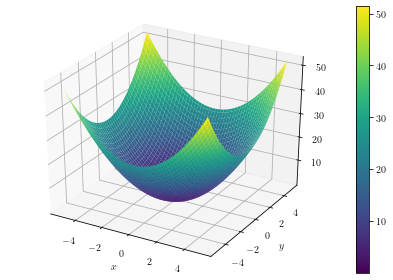

In [3]:
plot_test_function(objective_functions.F1, -5.12, 5.12)

2) F2 function (Rosenbrock function):
$$F_2(\mathbf{x}) = \sum_{i=1}^{n-1} \left(100(x_i^2 - x_{i+1})^2 + (1 - x_i)^2\right)$$

It is continuous, non-convex, unimodal, and
difficult because it has deep parabolic valleys
along the curves $x_{i+1} = x_i^2$.

Search is restricted to $[-2.048; 2.048]$ with step 0.001.

Minimum is attained at $\mathbf{x} = (1, \ldots, 1)^\top$
and equals $0$.


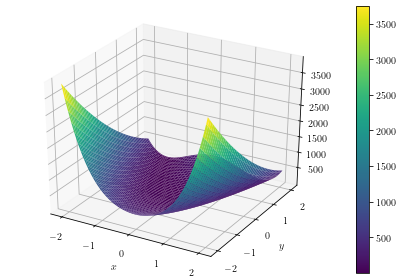

In [3]:
plot_test_function(objective_functions.F2, -2.048, 2.048)

In [ ]:
3) F3 function:
$$F_3(\mathbf{x}) = \sum_{i=1}^n [x_i]$$

It is discontinuous, non-convex, unimodal, and
piecewise-constant.

Search is restricted to $[-5.12; 5.12]$ with step 0.01.

Minimum is attained at $\mathbf{x} = (-5.12, \ldots, -5.12)^\top$
and equals $-6n$.

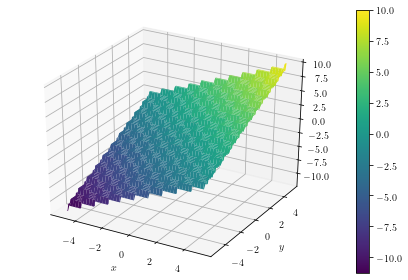

In [3]:
plot_test_function(objective_functions.F3, -5.12, 5.12)

4) F4 function:
$$F_4(\mathbf{x}) = \sum_{i=1}^n i x_i^4 + N(0, 1)$$

It is continuous, convex, unimodal, and
quartic. Most importantly, it is *stochastic*, in the sense
that on *each evaluation* it yields slightly different
results.

Search is restricted to $[-1.28; 1.28]$ with step 0.01.

Minimum (deterministic part) is of course at $\mathbf{x} = (0, \ldots, 0)^\top$
and equals $0$.

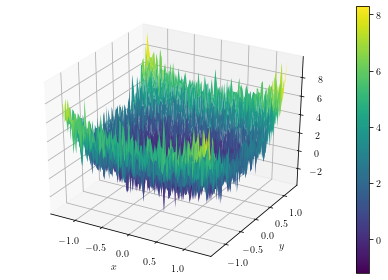

In [3]:
plot_test_function(objective_functions.F4, -1.28, 1.28)

5) F5 function:
$$F_5(x_1, x_2) = \left(\frac{1}{500} + \sum_{j=1}^{25} \frac{1}{f_j(x_1, x_2)}\right)^{-1}\;,$$
where
$$f_j(x_1, x_2) = j + \sum_{i=1}^2 (x_i - a_{ij})^6\;,$$
where

$\mathbf{a} =  \begin{pmatrix}
-32 & -16 & 0 & 16 & 32 & -32 & -16 & \ldots & 0 & 16 & 32\\
-32 & -32 & -32 & -32 & -32 & -16 & -16 & \ldots 32 & 32 & 32
\end{pmatrix}$

It is continuous, non-convex, non-quadratic, and multimodal,
making it especially hard to optimize.

Search is restricted to $[-65.536; 65.536]$ with step 0.001.

Minimum is attained at (approximately) $(-32, -32)^\top$
and equals $1$.


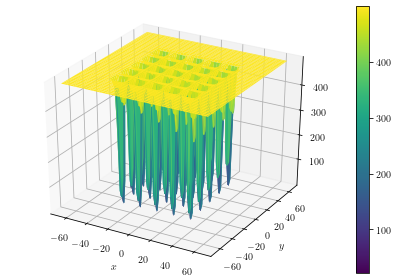

In [3]:
plot_test_function(objective_functions.F5, -65.536, 65.536)

f